In [2]:
import re
import bz2
import string
import numpy as np
import pandas as pd
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.corpus import twitter_samples  
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
train_data = []
with bz2.open(r'\Amazon Sentiment Analysis\train.ft.txt.bz2', "rt", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split(" ", 1)  
        if len(parts) == 2:
            label, text = parts
            label = 1 if label == "__label__2" else 0 
            train_data.append((label, text))


train_df = pd.DataFrame(train_data, columns=["label", "text"])

In [ ]:
test_data = []
with bz2.open(r'Amazon Sentiment Analysis\test.ft.txt.bz2', "rt", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split(" ", 1)  
        if len(parts) == 2:
            label, text = parts
            label = 1 if label == "__label__2" else 0 
            test_data.append((label, text))


test_df = pd.DataFrame(test_data, columns=["label", "text"])

In [5]:
train_df=pd.read_csv('amazon_reviews_train.csv')
test_df=pd.read_csv('amazon_reviews_test.csv')

In [6]:
train_df.to_csv('amazon_reviews_train.csv', index=False)
test_df.to_csv('amazon_reviews_test.csv', index=False)

In [7]:
train_df['label'].value_counts()

label
1    1800000
0    1800000
Name: count, dtype: int64

In [8]:
test_df['label'].value_counts()

label
1    200000
0    200000
Name: count, dtype: int64

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gokal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
stopwords_english = stopwords.words('english')

In [11]:
stemmer = PorterStemmer()

In [12]:
train_df

,label,text
0,1,Stuning even for the non-gamer: This sound tra...
1,1,The best soundtrack ever to anything.: I'm rea...
2,1,Amazing!: This soundtrack is my favorite music...
3,1,Excellent Soundtrack: I truly like this soundt...
4,1,"Remember, Pull Your Jaw Off The Floor After He..."
...,...,...
3599995,0,Don't do it!!: The high chair looks great when...
3599996,0,"Looks nice, low functionality: I have used thi..."
3599997,0,"compact, but hard to clean: We have a small ho..."
3599998,0,what is it saying?: not sure what this book is...


In [ ]:
import re
import string

def clean_data_from_df(train_df, test_df):
    """
    Bu fonksiyon, 'train' ve 'test' DataFrame'lerini alarak her birini temizler.
    - Sayıları ve noktalama işaretlerini kaldırır.
    - URL'leri '<url>' ile değiştirir.
    - Metni küçük harfe dönüştürür.
    - Stopwords ve özel semboller kaldırılır.

    Args:
    train_df: Eğitim verisi DataFrame'i.
    test_df: Test verisi DataFrame'i.

    Returns:
    train_labels: Temizlenmiş eğitim etiketleri.
    train_sentences: Temizlenmiş eğitim metinleri.
    test_labels: Temizlenmiş test etiketleri.
    test_sentences: Temizlenmiş test metinleri.
    """

    def clean_text(text):
        """Metni temizleyen yardımcı fonksiyon."""
        text = text.strip().lower()  

        text = re.sub(r'\d+', '', text)  
        text = re.sub(r'[^\w\s]', '', text) 
        

        text = re.sub(r'\$\w*', '', text)  
        text = re.sub(r'^RT[\s]+', '', text) 
        text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)  
        text = re.sub(r'#', '', text) 
        

        return text

    train_labels = train_df['label'].values
    test_labels = test_df['label'].values


    train_sentences = [clean_text(x) for x in train_df['text']]
    test_sentences = [clean_text(x) for x in test_df['text']]

    return train_labels, train_sentences, test_labels, test_sentences


In [14]:
train_labels, train_sentences, test_labels, test_sentences = clean_data_from_df(train_df, test_df)


In [ ]:
print(train_df['label'].unique()) 
print(test_df['label'].unique()) 

[1 0]
[1 0]


In [16]:
train_labels

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

In [17]:
train_sentences[0:2]

['stuning even for the nongamer this sound track was beautiful it paints the senery in your mind so well i would recomend it even to people who hate vid game music i have played the game chrono cross but out of all of the games i have ever played it has the best music it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras it would impress anyone who cares to listen _',
 'the best soundtrack ever to anything im reading a lot of reviews saying that this is the best game soundtrack and i figured that id write a review to disagree a bit this in my opinino is yasunori mitsudas ultimate masterpiece the music is timeless and im been listening to it for years now and its beauty simply refuses to fadethe price tag on this is pretty staggering i must say but if you are going to buy any cd for this much money this is the only one that i feel would be worth every penny']

In [18]:
train_sentences_df=pd.DataFrame(train_sentences)
test_sentences_df=pd.DataFrame(test_sentences)
train_labels_df=pd.DataFrame(train_labels)
test_labels_df=pd.DataFrame(test_labels)

In [19]:
train_sentences_df=train_sentences_df.rename(columns={0: 'text'})
test_sentences_df=test_sentences_df.rename(columns={0: 'text'})
train_labels_df=train_labels_df.rename(columns={0: 'label'})
test_labels_df=test_labels_df.rename(columns={0: 'label'})


In [20]:
train_labels_df.value_counts()

label
0        1800000
1        1800000
Name: count, dtype: int64

In [21]:
max_words = train_sentences_df['text'][150000:600000].str.split().apply(len).max()
print("Mean word number:", max_words)

Mean word number: 230


In [22]:
max_words = train_sentences_df['text'][150000:600000].str.split().apply(len).mean()
print("Mean word number:", max_words)

Mean word number: 78.58924888888889


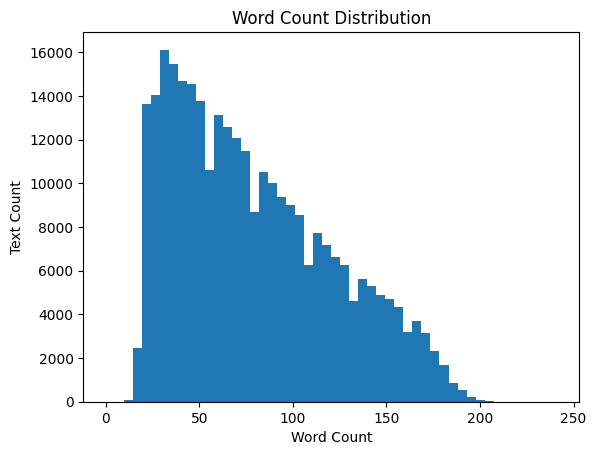

In [23]:
import matplotlib.pyplot as plt

word_counts = train_sentences_df['text'][0:300000].str.split().apply(len)

plt.hist(word_counts, bins=50)
plt.xlabel("Word Count")
plt.ylabel("Text Count")
plt.title("Word Count Distribution")
plt.show()

In [24]:
test_labels_df.value_counts()

label
0        200000
1        200000
Name: count, dtype: int64

In [25]:
max_features = 5000
maxlen = 100
embedding_dim=128

In [26]:
tokenizer = Tokenizer(num_words=max_features)

In [27]:
tokenizer.fit_on_texts(train_sentences)

In [28]:


tokenized_train = tokenizer.texts_to_sequences(train_sentences)

In [29]:
tokenized_test = tokenizer.texts_to_sequences(test_sentences)


In [30]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [31]:

X_train_padded = pad_sequences(tokenized_train, maxlen=maxlen, padding='post', truncating='post')


In [32]:
X_test_padded = pad_sequences(tokenized_test, maxlen=maxlen, padding='post', truncating='post')

In [144]:
from tensorflow.keras.layers import LSTM,Dense,Dropout,Embedding,GRU
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model = Sequential([

    Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=maxlen),
    

    LSTM(64, return_sequences=False), 
    

    Dropout(0.2),
    
    Dense(1, activation='sigmoid')  
])

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3,         
    restore_best_weights=True  
)


In [147]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 128)          640000    
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 689,473
Trainable params: 689,473
Non-trainable params: 0
_________________________________________________________________


In [148]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [149]:
model.fit(X_train_padded,np.array(train_labels) ,epochs=4, batch_size=32,callbacks=[early_stopping], validation_data=(X_test_padded, np.array(test_labels)))

Epoch 1/4
112500/112500 [==============================] - 3616s 32ms/step - loss: 0.1931 - accuracy: 0.9205 - val_loss: 0.1533 - val_accuracy: 0.9419
Epoch 2/4
 38813/112500 [=========>....................] - ETA: 37:12 - loss: 0.1493 - accuracy: 0.9437

KeyboardInterrupt: 

In [150]:
model.save("my_model.h5")

In [1]:
from tensorflow.keras.models import load_model

In [33]:
model = load_model("my_model.h5")

In [34]:
predictions = model.predict(X_test_padded)

12500/12500 [==============================] - 140s 11ms/step


In [35]:
predicted_labels = (predictions > 0.5).astype(int)

In [44]:
for i in range(5):
    print(f"True: {test_labels[i]}, Predicted: {predicted_labels[i][0]}")

True: 1, Predicted: 1
True: 1, Predicted: 1
True: 0, Predicted: 0
True: 1, Predicted: 1
True: 1, Predicted: 1


In [59]:
def clean_text_fast(text):
    text = text.lower().strip()
    text = re.sub(r'https?:\/\/\S+', '', text)  
    text = re.sub(r'[^a-zA-Z\s]', '', text) 
    return text

In [53]:
def predict_sentiment(texts, tokenizer, maxlen=100):
    """Liste halinde verilen metinlerin duygu analizini hızlıca yapar."""
    texts = [clean_text_fast(text) for text in texts] 
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')


    predictions = model.predict(padded_sequences)

    return ["Pozitive" if p > 0.5 else "Negative" for p in predictions]

In [54]:
test_texts = [
    "This product is amazing! I love it!",  
    "Absolutely terrible, waste of money.",  
    "Not bad, but could be better.",
]

In [56]:
predicted_results = predict_sentiment(test_texts, tokenizer)

1/1 [==============================] - 0s 14ms/step


In [57]:
for text, sentiment in zip(test_texts, predicted_results):
    print(f"Input: {text} → Prediction: {sentiment}")

Input: This product is amazing! I love it! → Prediction: Pozitive
Input: Absolutely terrible, waste of money. → Prediction: Negative
Input: Not bad, but could be better. → Prediction: Pozitive


In [60]:
Classification_Report=classification_report(predicted_labels,test_labels)

In [62]:
print(Classification_Report)

              precision    recall  f1-score   support

           0       0.95      0.93      0.94    205496
           1       0.93      0.95      0.94    194504

    accuracy                           0.94    400000
   macro avg       0.94      0.94      0.94    400000
weighted avg       0.94      0.94      0.94    400000

